In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
# flatmaps_per_question = __import__('06_flatmaps_per_question')
import viz
import gemv

Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### load gemv average flatmaps

In [2]:
gemv_flatmaps_pilot = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot.pkl'))
gemv_flatmaps_pilot5 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot5.pkl'))
gemv_flatmaps_dict = gemv_flatmaps_pilot | gemv_flatmaps_pilot5
qa_questions_list, gemv_questions_list = gemv.get_matched_lists()

In [3]:
# # check that gpt4 was run for all the questions
# subject = 'UTS02'
# setting = 'individual_gpt4'
# flatmaps_qa = joblib.load(
#     join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
# for k in qa_list:
#     assert k in flatmaps_qa.keys()

### make comparisons

/home/chansingh/fmri/qa_results/gemv/corrs_full_35
/home/chansingh/fmri/qa_results/gemv/corrs_full_35
/home/chansingh/fmri/qa_results/gemv/corrs_full_35
/home/chansingh/fmri/qa_results/gemv/corrs_full_35
/home/chansingh/fmri/qa_results/gemv/corrs_full_35
/home/chansingh/fmri/qa_results/gemv/corrs_full_35


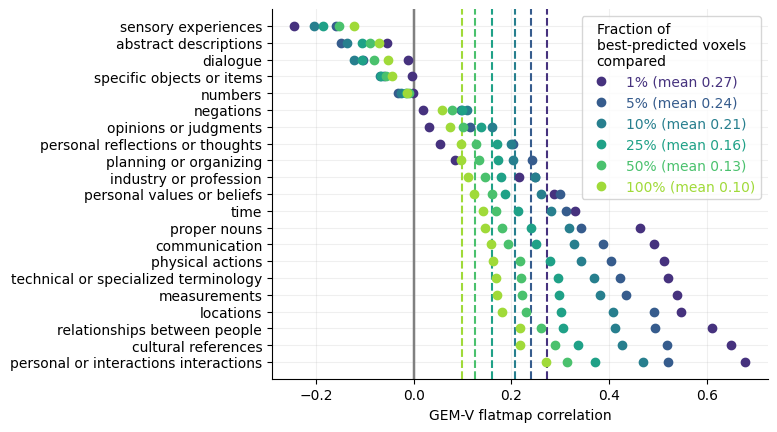

In [4]:
# load qa weights
subject = 'UTS02'
corrs_df_dict = {}
frac_voxels_to_keep_list = [0.01, 0.05, 0.1, 0.25, 0.5, 1]
for j, frac_voxels_to_keep in enumerate(frac_voxels_to_keep_list):
    flatmaps_qa_list = defaultdict(list)
    # , 'individual_35', full_35', 'shapley_35', 'individual_gpt4',
    # for setting in ['individual_gpt4', 'shapley_35']:
    # for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
    # , 'shapley_35']:
    # for setting in ['individual_gpt4']:
    # for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
    # , 'individual_gpt4', 'individual_gpt4_wordrate']:
    for setting in ['full_35']:
        flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    # print('lens', [len(flatmaps_qa_list[q]) for q in flatmaps_qa_list.keys()])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()}

    # select what to plot
    # df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')
    questions_names_df = pd.DataFrame({
        'qa': qa_questions_list,
        'gemv': gemv_questions_list,
    })
    # filter only questions that exist in the flatmaps
    questions_names_df = questions_names_df[questions_names_df['qa'].isin(
        flatmaps_qa_dict.keys())]

    if isinstance(flatmaps_qa_dict, pd.DataFrame):
        questions_names_df = questions_names_df[questions_names_df['qa'].isin(
            flatmaps_qa_dict.index)]
        flatmaps_qa_list = flatmaps_qa_dict.loc[questions_names_df['qa'].values]['weights'].values
    else:
        flatmaps_qa_list = [flatmaps_qa_dict[q]
                            for q in questions_names_df['qa'].values]
    flatmaps_gemv_list = [
        gemv_flatmaps_dict[q]
        for q in questions_names_df['gemv'].values]
    titles_gt = questions_names_df['gemv'].apply(
        lambda x: x[0]).astype(str)

    # mask flatmaps by corr
    # corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
    #     'UT', ''), 'corrs_test_35.pkl')).values[0]
    # corrs_test_mask = (corrs_test >= np.percentile(
    #     corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)

    # flatmaps_qa = [flatmaps_qa[i][corrs_test_mask]
    #                for i in range(len(flatmaps_qa))]
    # flatmaps_gemv = [flatmaps_gemv[i][corrs_test_mask]
    #                  for i in range(len(flatmaps_gemv))]

    # mask flatmaps by extreme vals
    for i in range(len(flatmaps_qa_list)):
        mask_extreme = np.abs(flatmaps_qa_list[i]) >= np.percentile(
            np.abs(flatmaps_qa_list[i]), 100 * (1 - frac_voxels_to_keep))
        flatmaps_qa_list[i] = flatmaps_qa_list[i][mask_extreme]
        flatmaps_gemv_list[i] = flatmaps_gemv_list[i][mask_extreme]

    # # save flatmaps
    # if frac_voxels_to_keep in [0.1, 1]:

    #     # apply mask as nans
    #     for i in range(len(flatmaps_qa)):
    #         flatmaps_qa[i][~corrs_test_mask] = np.nan
    #         flatmaps_gemv[i][~corrs_test_mask] = np.nan

    #     for i in tqdm(range(len(flatmaps_qa))):
    #         sasc.viz.quickshow(
    #             flatmaps_qa[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             setting, f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    #         sasc.viz.quickshow(
    #             flatmaps_gemv[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             'gemv', f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    # shuffle gemv
    # random.shuffle(flatmaps_gemv)

    # print num nas
    # print('nas', [np.isnan(flatmaps_gemv[i]).sum()
    #   for i in range(len(flatmaps_gemv))])

    corrs = viz._calc_corrs(
        flatmaps_qa_list,
        flatmaps_gemv_list,
        titles_qa=[analyze_helper.abbrev_question(q)
                   for q in questions_names_df['qa'].astype(str)],
        titles_gt=titles_gt,
    )
    # corrs_df = pd.DataFrame({'corrs': np.diag(
    # corrs.values), 'questions': corrs.columns}).sort_values('corrs', ascending=False)
    # corrs_df_dict[frac_voxels_to_keep] = corrs_df.copy()
    corrs_df_dict['questions'] = corrs.columns
    corrs_df_dict[f'corrs_{frac_voxels_to_keep}'] = np.diag(corrs.values)

    # corrs_df.to_pickle(join(repo_dir, 'qa_results', 'gemv',
    # setting + '_corrs_df.pkl'))

    colors = sns.color_palette('viridis', len(frac_voxels_to_keep_list))
    viz.corr_bars(
        corrs,
        out_dir_save=join(repo_dir, 'qa_results', 'gemv',
                          'corrs_' + setting),
        xlab='GEM-V',
        color=colors[j],
        label=f'{frac_voxels_to_keep * 100:.0f}%',
    )
    # plt.savefig(join(out_dir_save, 'corrs_barplot.pdf'), bbox_inches='tight')
    # plt.savefig(join(out_dir_save, 'corrs_barplot.png'),
    #             bbox_inches='tight', dpi=300)
    # plt.show()

# center legend text
plt.legend(title='Fraction of\nbest-predicted voxels\ncompared',
           labelcolor='linecolor')
# plt.tight_layout()
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, 'corrs_barplot.pdf'),
            bbox_inches='tight')
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, 'corrs_barplot.png'),
            bbox_inches='tight', dpi=300)
plt.show()

### compute p-values with eng1000

In [5]:
flatmaps_eng1000 = joblib.load(
    join(PROCESSED_DIR, subject.replace('UT', ''), 'eng1000_weights.pkl'))

In [6]:
corrs_df = pd.DataFrame(corrs_df_dict)
for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    pvals = []
    for i in range(len(flatmaps_qa_list)):
        if frac_voxels_to_keep < 1:
            mask_extreme = np.abs(flatmaps_qa_list[i]) >= np.percentile(
                np.abs(flatmaps_qa_list[i]), 100 * (1 - frac_voxels_to_keep))
        else:
            mask_extreme = np.ones(flatmaps_qa_list[i].shape).astype(bool)

        flatmaps_eng1000_masked = flatmaps_eng1000[:, mask_extreme]
        flatmaps_qa_masked = flatmaps_qa_list[i][mask_extreme]

        # calculate correlation between each row of flatmaps_qa_masked and flatmaps_eng1000_masked
        flatmaps_eng1000_masked_norm = StandardScaler(
        ).fit_transform(flatmaps_eng1000_masked.T).T
        flatmaps_qa_masked_norm = (
            flatmaps_qa_masked - flatmaps_qa_masked.mean()) / flatmaps_qa_masked.std()
        corrs_perm_eng100_arr = flatmaps_eng1000_masked_norm @ flatmaps_qa_masked_norm / \
            flatmaps_qa_masked_norm.shape[0]

        pvals.append((corrs_perm_eng100_arr >
                      corrs_df[f'corrs_{frac_voxels_to_keep}'].values[i]).mean())

    # get what fraction of 'corrs_perm_eng1000' column is greater than 'corrs'
    corrs_df[f'pval_{frac_voxels_to_keep}'] = pvals

 50%|█████     | 3/6 [00:05<00:06,  2.04s/it]

100%|██████████| 6/6 [00:43<00:00,  7.30s/it]


In [7]:
# format scientific notation
corrs_df.sort_values(
    by='pval_0.01').style.background_gradient().format(precision=3)

,questions,corrs_0.01,corrs_0.05,corrs_0.1,corrs_0.25,corrs_0.5,corrs_1,pval_0.01,pval_0.05,pval_0.1,pval_0.25,pval_0.5,pval_1
0,time,0.216,0.204,0.203,0.179,0.160,0.141,0.016,0.129,0.126,0.102,0.089,0.076
2,locations,0.678,0.518,0.426,0.302,0.229,0.181,0.053,0.062,0.075,0.111,0.119,0.122
14,physical actions,0.491,0.494,0.408,0.295,0.219,0.163,0.081,0.090,0.104,0.119,0.140,0.154
20,technical or specialized terminology,0.650,0.492,0.411,0.298,0.222,0.168,0.101,0.115,0.119,0.131,0.153,0.169
5,cultural references,0.609,0.519,0.469,0.371,0.290,0.218,0.119,0.112,0.098,0.095,0.109,0.117
10,opinions or judgments,0.330,0.249,0.198,0.138,0.101,0.074,0.126,0.185,0.204,0.234,0.257,0.308
1,measurements,0.519,0.422,0.369,0.278,0.218,0.170,0.138,0.126,0.128,0.135,0.145,0.151
12,personal reflections or thoughts,0.512,0.341,0.261,0.171,0.127,0.096,0.169,0.181,0.193,0.214,0.232,0.238
17,relationships between people,0.538,0.433,0.381,0.306,0.261,0.217,0.170,0.138,0.111,0.089,0.078,0.069
13,personal values or beliefs,0.546,0.404,0.342,0.239,0.169,0.123,0.178,0.162,0.159,0.178,0.199,0.213


# Look at merged flatmaps

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results', 'gemv',
                               setting + '_corrs_df.pkl'))

In [ ]:
img_parent_dir = join(repo_dir, 'qa_results', 'gemv',
                      subject, 'frac_voxels=0.1')
img_dir1 = join(img_parent_dir, 'gemv')
img_dir2 = join(img_parent_dir, setting)

# read images and combine them with their filenames on a single plot
# fnames = os.listdir(img_dir1)
# fnames = [f for f in fnames if f.endswith('.png')]
# only keep the ones that are in both directories
# fnames = [f for f in fnames if f in os.listdir(img_dir2)]


# corrs = corrs.sort_values('corrs', ascending=False)
fnames = [v + '.png' for v in corrs_df['questions'].values]

n = len(fnames)
C = 4
R = int(np.ceil(n / C))

fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].axis('off')
for i, fname in enumerate(fnames):
    img1 = plt.imread(join(img_dir1, fname))
    img2 = plt.imread(join(img_dir2, fname))
    axs[i].imshow(np.concatenate([img1, img2], axis=1))
    axs[i].set_title(
        f'{fname[:-4]} ({corrs_df["corrs"].values[i]:0.3f})', fontsize=8)

# add text in bottom right of figure
fig.text(0.99, 0.01, f'{subject}\nGEMV on left, QA on right',
         ha='right', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig(join(img_parent_dir, f'flatmaps_{setting}_{subject}.png'), dpi=300)
plt.close()